## Practical Exploration of the Delta Rule
University of Kent

CO636/836

Marek Grzes

Last modified 21/11/2021

This exploration complements Sec. 5.3 in O'Reilly & Munakata (2000) that introduces the delta rule for the Summed Squared Error (SSE) and linear activation. We apply the delta rule to a tiny classification problem with two classes. Since we are interested in classification, the delta rule with a sigmoidal activation (i.e. logistic regression) would be more appropriate for this problem in general, but we start with the linear activation for didactic reasons. The implications of using sigmoidal activation in the delta rule are presented in Sec. 5.4 in the textbook, and we use this fact in the final questions that are at the end of this notebook.

The source code of this notebook can be found here:
<small>
<a href="https://github.com/mgrzes/python-delta-rule/blob/main/delta-rule-exploration.ipynb">https://github.com/mgrzes/python-delta-rule/blob/main/delta-rule-exploration.ipynb</a></small>

### Generate Data

We generate a small dataset with two variables $x$ and $y$, and a binary class
attribute with values $-1$ and $1$. The data is generated from two normal
distributions in which the variables $x$ and $y$ are not uncorrelated.

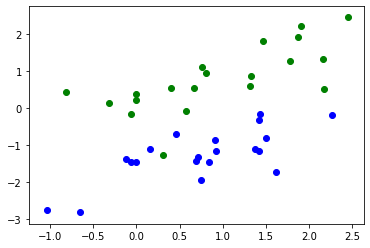

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# the number of data points per class
num_points = 20

# data points for class -1
data1 = np.random.multivariate_normal([1,1], [[0.8, 0.6],[0.6, 0.7]], num_points)
# data points for class 1
data2 = np.random.multivariate_normal([1,-1], [[0.8, 0.6],[0.6, 0.7]], num_points)

# plot both arrays
# note that arrays are indexed [row, col]
plt.scatter(data1[:,0], data1[:,1], c='green')
plt.scatter(data2[:,0], data2[:,1], c='blue')
plt.show()

Next, we add the class attribute in the third column, and we combine the two parts into one array.

In [2]:
# we create one dataset with the class attribute
# 1) add one column with the class label
# create the class labels for both classes
c0 = - np.ones([num_points, 1])
c1 = np.ones([num_points, 1])
# Append the class labels to both datasets;
# Note that the data points in data1 will have -1 in the third
# column and the data points in data2 will have +1.
data1 = np.append(data1, c0, axis=1)
data2 = np.append(data2, c1, axis=1)
# 2) combine the two classes in one data array
data = np.append(data1, data2, axis=0)

# we shuffle the data by rows because we want positive and negative examples to be interleaved; the delta rule algorithm below will update the weights after processing one data example, i.e. we won't use batches or mini-batches.
np.random.shuffle(data)

# print the first 5 rows to see what the data looks like
print(data[:5])

[[ 1.50110876 -0.79844548  1.        ]
 [ 0.74770503 -1.93921639  1.        ]
 [ 0.80919882  0.96893246 -1.        ]
 [ 0.40140358  0.54056617 -1.        ]
 [-0.80952675  0.44713941 -1.        ]]


Our dataset with two classes is now in `data`. We plot it below. The two colours correspond to the two classes, i.e., the values of the class attribute.

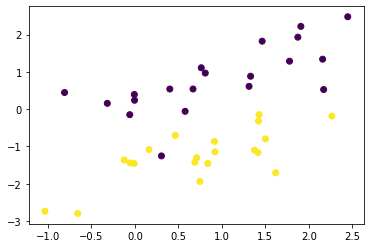

In [3]:
plt.scatter(data[:,0], data[:,1], c=data[:,2] )
plt.show()

## Delta Rule

We will use the delta rule algorithm to solve our classification problem. The variables
$t_k$ and $o_k$ are used to be consistent with the textbook (O'Reilly & Munakata 2000).

The code that is below uses the delta rule update equation:

$\Delta w_{i,k}=\epsilon(t_k-o_k)s_i$.

This equation is presented in Eq. (5.3) in O'Reilly & Munakata (2000).

In [4]:
# A coroutine that receives data and prints it. To make the core
# algorithm easier to read, we will start this coroutine to print
# the intermediate results.
def printer():
    i = 0
    line=""
    while True:
        vec = yield
        if vec.size == 1:
            if i > 0:
                # print anything that is left in the buffer
                print(line)
                i = 0
                line = ""
        else:
            i = i + 1
            line = line + " " + str(np.round(vec,4))
            if i % 4 == 0:
                print(line)
                line = ""
                i = 0

printer_handler = printer()
# start the printer
printer_handler.send(None)

# we need 3 parameters/weights: one for x, one for y, and one for the bias term; we initialise them randomly
w = np.random.normal(0, 0.5, 3)
# learning rate
epsilon = 0.05
delta = 100
iteration = 0
# precision is used to check if the changes are small enough and the execution can be terminated
precision=0.01

while delta > precision and iteration < 10:
    iteration = iteration + 1
    # to be consistent with the textbook, we will process one data point at a time
    for s in data:
        # compute the linear activation (predicted output)
        s_with_bias = np.copy(s)
        s_with_bias[2] = 1 # the last element (the class) is overwritten here to be used as the bias activation
        o_k =  w.dot(s_with_bias) # see Eq. 5.6 in O'Reilly & Munakata (2000)
        t_k = s[2]
        # the delta rule equation in the vector form
        delta_w = epsilon * (t_k - o_k) * s_with_bias # see Eq. 5.3 in O'Reilly & Munakata (2000)
        w = w + delta_w
        # if the max change is tiny, we will stop learning in the while loop
        delta=np.max(np.absolute(delta_w))
        # print the current weights
        printer_handler.send(w)

# print the remaining values if there are any
printer_handler.send(np.zeros([1,1]))

 [-0.0413  0.3794 -0.5504] [ 0.0453  0.1548 -0.4346] [ 0.0149  0.1183 -0.4722] [ 0.0029  0.1022 -0.5021]
 [ 0.0248  0.0901 -0.5291] [ 0.0261  0.0934 -0.5519] [-0.0688 -0.1577 -0.4602] [-0.0148 -0.2514 -0.3958]
 [ 0.0213 -0.3261 -0.3434] [ 0.0308 -0.3308 -0.3733] [ 3.000e-04 -3.450e-01 -3.965e-01] [-0.0139 -0.4054 -0.3749]
 [ 0.0815 -0.4152 -0.3082] [ 0.0527 -0.4344 -0.3299] [ 0.0934 -0.4773 -0.3047] [ 0.0963 -0.4738 -0.3027]
 [ 0.1409 -0.5095 -0.2703] [ 0.1411 -0.5199 -0.2967] [ 0.1445 -0.5164 -0.2949] [ 0.1181 -0.5355 -0.3097]
 [ 0.046 -0.553 -0.343] [ 0.0253 -0.551  -0.3787] [ 0.0236 -0.5932 -0.3494] [ 0.083  -0.5241 -0.3182]
 [ 0.0768 -0.5332 -0.3264] [ 0.0981 -0.5654 -0.2806] [ 0.1663 -0.5807 -0.2326] [ 0.179  -0.604  -0.2147]
 [ 0.14   -0.6283 -0.2328] [ 0.1442 -0.657  -0.2064] [ 0.159  -0.6753 -0.1903] [ 0.1592 -0.6831 -0.2227]
 [ 0.2236 -0.6178 -0.1963] [ 0.2213 -0.6438 -0.1773] [ 0.2212 -0.6615 -0.1651] [ 0.227  -0.6663 -0.161 ]
 [ 0.2059 -0.6834 -0.1925] [ 0.2738 -0.6889 -0.16

## The Final Decision Boundary and the Threshold

The class attribute in our `data` object has values -1 and 1 whereas the outputs of the linear model are between minus and plus infinity. This means that we need to introduce a threshold that will allow us to map the continuous output to the class value. A threshold of zero is a good default choice because it lies between -1 and 1. With that all the output activations that are negative will be mapped to class -1, and all the output activations that are positive or zero will be mapped to class +1.

The ensuing decision boundary in 3D is $z=w[0]\times x + w[1]\times y + w[2]$. When the threshold is zero, this boundary in the 2D space defined by the xy-plane becomes $y = -\frac{w[0]}{w[1]}\times x-\frac{w[2]}{w[1]}$. This boundary will be shown as a red line in the figure below.

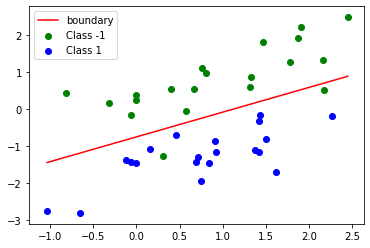

In [5]:
# plot the final line

# construct the line using 100 points
x = np.linspace(np.min(data[:,0]),np.max(data[:,0]),100)
# this equation corresponds to our decision boundary on the xy-plane when the threshold is zero; see the discussion above
y = -w[0]/w[1]*x-w[2]/w[1]
ymin = np.min(data[:,1])
ymax = np.max(data[:,1])

# plot the data and the line
plt.ylim(ymin-0.3, ymax+0.3)
# plot two classes separately
plt.scatter(data1[:,0], data1[:,1], c='green', label='Class -1' )
plt.scatter(data2[:,0], data2[:,1], c='blue', label='Class 1' )
plt.plot(x, y, '-r', label='boundary')
plt.legend()
plt.show()

## Error on Training Data

The delta rule algorithm executed above gave us the vector of weights $w$. This vector represents our solution, and we can call it our model.

Now, we will compute the number of errors on the training data, assuming that our model is $w$. The first type of errors that we compute below are classification errors, i.e., we apply the threshold of $0$ to decide whether the class is -1 or +1. The second type of errors are the explicit differences between the predicted output and the class attribute. You will see in the questions below that having both errors we will be in a better position to gain deeper insights into the properties of delta rule.

In [6]:
# we need to add bias activations in the last column
data_with_bias = np.copy(data)
data_with_bias[:,2]=1

# predictions are the outputs computed by the linear model
predictions = w.dot(data_with_bias.transpose())

# compute the summed squared error with respect to the linear activation; i.e., we want to see see how well the linear function approximates the values of our class attribute
SSE = np.sum(np.square(predictions-data[:,2]))

# this is the same threshold that we used to derive the red decision boundary above; with this threshold, our classification below will be consistent with the red line above
threshold = 0

# apply threshold to make discrete decisions
predictions[predictions<threshold] = -1
predictions[predictions>=threshold] = 1
# print(predictions)
# print(data[:,2])

# diff will be zero when the classification is correct
diff = predictions - data[:,2]
# indices of data items with incorrect predictions
erroneous = diff.nonzero()[0]
# count the number of incorrect predictions
accuracy = np.size(erroneous)

print("SSE on training data: " + str(SSE) )
print("Number of errors on training data: " + str(accuracy) )

SSE on training data: 9.832118981452384
Number of errors on training data: 2


## Questions

You are not required to answer all the questions that are below. I would encourage you to attempt the first five. The last three questions require a certain amount of coding in Python, and they can be skipped by those who are not interested in further exploration.

1. Read this notebook and analyse all sections trying to understand them and trying to see the link with the textbook and the lectures.

2. The red line in Sec. _"The Final Decision Boundary and the Threshold"_ is the decision boundary for our classification problem, and it corresponds to the threshold of zero. How would this decision boundary change if the threshold was smaller or greater than zero? Note which data points have the class -1 and which +1; this can be seen in the legend in the figure. You may want to do subsequent questions first if this question is challenging for you initially.

3. Add the computation of the Summed Squared Error (SSE) in the `while` loop of the learning algorithm and print its value. Note that we are interested in the SSE between the true class value and the linear output of our neural network because this is what our current implementation if the delta rule optimises.

4. In the current implementation, the final decision boundary (the red line in the figure above) is plotted after the learning process has finished. Your task is to plot the data and the current boundary in the `while` or `for` loop of the learning algorithm. The goal is to investigate how the decision boundary is changing during learning, and to contrast those changes with the changes in the SSE that will be printed at the same time after you have implemented step 3. We want to see the decision boundary after every application of the delta rule equation; now, we can only see this boundary after the learning process has terminated.

5. If you run the simulation several times, you will notice that the SSE may be non-zero even if the number of classification errors on the training data is zero or close to zero. Explain how this is possible. In your explanation, study and analyse the differences between the SSE and classification errors that are computed in this document. Even if you don't do subsequent questions, try to analyse those two errors and their relationship in detail.

6. The decision boundary that is learned has the form: $z=w[0]\times x+w[1]\times y+w[2]$ where $z$ is the last (third) column in our training data, and it represents the class attribute.  Similarly, $x$ and $y$ are the first and the second columns in the data array respectively. This means that, strictly speaking, the decision boundary is a plane located in a 3-dimensional xyz-space. Explain how this plane is placed with respect to the flat scatterplot of the data examples in their xy-plane (i.e. the graph with the red line above). After trying to estimate the location of the separating hyperplane in 3D, you could construct a 3-dimensional version of this plot to see where exactly this plane is located. An example 3D scatterplot in mathplotib is here https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html

7. Add the sigmoidal activation to our implementation of delta rule. Note that assuming that we are switching to the Cross-Entropy error (CE) instead of the Summed Squared Error (SSE), the update equation for the delta rule remains unchanged. The only difference is the activation function that is sigmoidal and takes the original linear activation as input. This is well explained in Sec. 5.4 in O'Reilly & Munakata (2000). Since the range of the sigmoid function is the interval $[0,1]$, it would make sense to replace the class -1 with 0 in our data. So, when you are working on this question, your classes should be 0 and 1 in the `data` object.

8. When your implementation of question 7 is complete, repeat question 6 and apply its analysis and your code to the new problem with the sigmoidal activation. At this point, you will have two pretty visualisations that will show you the properties of the linear and sigmoidal activations, and their impact on the classification and SSE errors.

## References

O'Reilly, Randall C., and Yuko Munakata. Computational explorations in cognitive neuroscience: Understanding the mind by simulating the brain. MIT press, 2000.


<small>This document was written in Pycharm Professional and compiled using Python 3.8 with standard packages available in Ubuntu 20.04.</small>
